# Crop Classification

The project focus three stages of crop cylce, please follow below link for know about the stages. 

[Crop details](https://docs.google.com/drawings/d/1oyH4NqZqckdJBXbudCC-5BtxOSA5LPmg3pojAGm8RP4/edit?usp=sharing)

Project focuses on 7 classes of crops which is divided into 4 different categories depending upon the respective crop cycle.


| crop      | crop_class |
| ----------- | ----------- |
| barley_w      | 1       |
| wheat_w   | 2        |
| rapeseed_w      | 3       |
| rye_w   | 4        |
| barley_s      | 5       |
| wheat_s   | 6        |
| oats_s   | 7       |



## Know the crop data

#### Import

In [1]:
import pandas as pd
import numpy as np
import rioxarray
import os
import geopandas as gpd
import rasterio
import shapely
import fiona
from tqdm import tqdm
from shutil import copyfile

import rasterio.mask
import sys
from pathlib import Path


from common import coco_utils
from data_op import rasterfile as rf
from data_op import shapefile
from config import settings as st
from common import dictionary_utils
import data_op.shape_opr as so
from config import config as cfg
from config import classes as classes
import json

In [25]:
crop_classes = pd.read_excel(os.path.join(st.data_directory,'crop_code/croptable_2019.xlsx'))

In [26]:
crop_classes

Crop_nr                                               Name
0          1                                      Spring barley
1          2                                       Spring wheat
2          3                                        Spring oats
3          4                         Mix of spring sown cereals
4          5                                 Maize for maturity
..       ...                                                ...
324      966  Grass/clovergrass for factory with less than 5...
325      968                              Mandatory catch crops
326      970     Undersowing and catch crops for green manuring
327      972                                         Intercrops
328      975              Grass, mowing before spring-sown crop

[329 rows x 2 columns]

In [27]:
crop_classes_list = np.unique(crop_classes.Crop_nr)
print(len(crop_classes_list))

329


Distinct crop classes and names for 7 crops, divided into 4 categories depending upon the respective crop cycle, 

**Categories**

| Index      | Months |
| ----------- | ----------- |
| 1      |  Jan-Mar      |
| 2   | Apr-Jun        |
| 3      | Jul-Sep       |
| 4   | Oct-Nov        |

**Category wise crop classes**

</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |

</br>
</br>

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |
| barley_s   | 01,701      | planting and mid |
| wheat_s      | 02,06,702     | planting and mid  |
| oats_s      | 03,703    | planting and mid  |

</br>
</br>


**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706,220     | mid and harvest |
| wheat_w   | 707,221       | mid and harvest|
| rye_w      | 222     | harvest |
| barley_s   | 701,210      | mid and harvest |
| wheat_s      | 702,211     | mid and harvest |
| oats_s      | 703,212    | mid and harvest  |

</br>
</br>
  

**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     | 10    | planting|
| wheat_w   | 11,13      | planting|
| rapeseed_w      | 22     | planting |
| rye_w      | 14,15     | planting |
| barley_s   | 210      | harvest |
| wheat_s      | 211     | harvest |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

Summmer and Winter crop categorisation

| Season      | crop |
| ----------- | ----------- |
| Winter      | barley_w, wheat_w, rapeseed_w, rye_w       |
| Summer/Spring   | barley_s,wheat_s,oats_s        |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |
| barley_s   | 01      | planting and mid  |
| wheat_s      | 02,06     | planting and mid |
| oats_s      | 03   | planting and mid |

**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid and harvest |
| wheat_w   | 11,13       | mid and harvesst|
| rye_w      | 14,15      | harvest |
| rapeseed_w      | 22     | harvest |
| barley_s   | 01     | mid and harvest |
| wheat_s      | 02,06     | mid and harvest |
| oats_s      | 03   | mid and harvest  |

**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | planting |
| wheat_w   | 11,13       | planting|
| rye_w      | 14,15      | planting |
| rapeseed_w      | 22     | planting |
| barley_s   | 01     |  harvest |
| wheat_s      | 02,06     | harvest |






## Prepare Shapefiles



In [2]:
# Create 4 shapefiles from 4 categorise 
path_raw = 'Raw_shape_files/Raw_downloaded_files'
shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(st.data_directory,path_raw,'Denmark_shape_2020/Marker_2020.shp'))
denmark_veg = shape_ex.import_shape()


In [3]:
denmark_veg

Marknr  IMK_areal   Journalnr       CVR  Afgkode  \
0        VSF 5      15.28  20-0004414  28422733    318.0   
1        VSF 6      18.87  20-0004414  28422733    318.0   
2        VSF 7      21.02  20-0004414  28422733    254.0   
3       filsø6       2.66  20-0004414  28422733    250.0   
4       fjan10       3.92  20-0004414  28422733    254.0   
...        ...        ...         ...       ...      ...   
583669    65-0       9.18  20-0030324  31106605      NaN   
583670    64-0      16.08  20-0030324  31106605      NaN   
583671     1-0       5.46  20-0018854  21405051      NaN   
583672    80-0       8.09  20-0030324  31106605      NaN   
583673     3-1       1.52  20-0018854  21405051      NaN   

                                      Afgroede   GB   Markblok  GBanmeldt  \
0          MVJ ej udtagning, ej landbrugsareal  0.0  447232-86       0.00   
1          MVJ ej udtagning, ej landbrugsareal  0.0  447232-86       0.00   
2       Miljøgræs MVJ-tilsagn (0 N), permanent  1.0  447232-86      21.02   
3           Permanent græs, meget lavt udbytte  1.0  463234-72       2.66   
4       Miljøgræs MVJ-tilsagn (0 N), permanent  1.0  445243-99       3.92   
...                                        ...  ...        ...        ...   
583669                                    None  NaN  511161-68        NaN   
583670                                    None  NaN  511161-97        NaN   
583671                                    None  NaN  479172-61        NaN   
583672                                    None  NaN  512160-07        NaN   
583673                                    None  NaN  479172-61        NaN   

                                                 geometry  
0       POLYGON ((447095.808 6232154.360, 447097.965 6...  
1       POLYGON ((447414.977 6232743.568, 447416.902 6...  
2       POLYGON ((447968.632 6232132.837, 447968.701 6...  
3       POLYGON ((463635.528 6233882.395, 463592.872 6...  
4       POLYGON ((445791.067 6243928.038, 445791.721 6...  
...                                                   ...  
583669  POLYGON ((511539.465 6161423.150, 511531.294 6...  
583670  POLYGON ((511622.497 6161362.253, 511618.345 6...  
583671  POLYGON ((479566.600 6172007.170, 479566.690 6...  
583672  POLYGON ((511350.042 6160285.812, 511350.561 6...  
583673  POLYGON ((479378.050 6171989.210, 479378.740 6...  

[583674 rows x 10 columns]

In [4]:
#rename column 
denmark_veg.reset_index(drop=True, inplace=True)
denmark_veg = denmark_veg.rename(columns = {'Afgkode':'code'},errors='raise')
columns_to_be_remove= ['Marknr', 'IMK_areal', 'Journalnr', 'CVR', 'Afgroede', 'GB', 'GBanmeldt','Markblok']
denmark_veg = shape_ex.filter_shape_data(df = denmark_veg,column_names = columns_to_be_remove)

In [5]:
np.unique(denmark_veg.geometry.type)

array(['Polygon'], dtype=object)

In [37]:
# category 1 jan-march
classes_for_cat_1 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22]
    }
denmark_veg_cat_1 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_1,id_col = 'code',label_name='classes')

<AxesSubplot:>

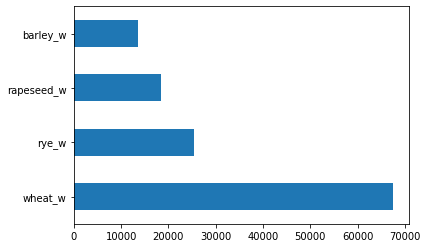

In [38]:
denmark_veg_cat_1['r_classes'].value_counts().plot(kind='barh')

In [40]:
print(denmark_veg_cat_1)
denmark_veg_cat_1.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2019','Jan_Mar.shp'))

              ID  code                                           geometry  \
0       62036785  15.0  POLYGON ((582613.488 6143186.646, 582633.409 6...   
1       62036787  15.0  POLYGON ((582770.074 6143374.482, 582781.991 6...   
2       62036790  15.0  POLYGON ((582889.547 6143116.659, 582919.988 6...   
5       61795773  22.0  POLYGON ((577930.531 6132994.356, 577927.620 6...   
9       61795835  11.0  POLYGON ((578541.620 6131084.198, 578544.376 6...   
...          ...   ...                                                ...   
587407  88484926  14.0  POLYGON ((505966.180 6114696.228, 505959.461 6...   
587408  88484900  14.0  POLYGON ((505973.022 6114728.346, 505982.542 6...   
587440  88484892  11.0  POLYGON ((477791.947 6204671.881, 477793.203 6...   
587443  88484899  11.0  POLYGON ((477365.500 6201599.693, 477277.860 6...   
587446  88484905  11.0  POLYGON ((478751.003 6205832.741, 478750.942 6...   

         r_classes  r_code  
0            rye_w       3  
1            rye_

<AxesSubplot:>

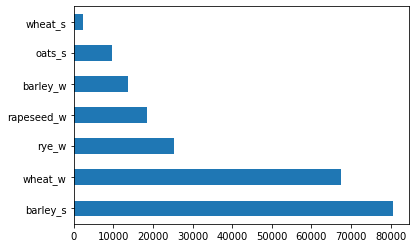

In [41]:
# category 2 Apr-jun and jul-sep
classes_for_cat_2 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22],
    'barley_s': [1],
    'wheat_s' :[2,6],
    'oats_s':  [3]	
    }
denmark_veg_cat_2 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_2,id_col = 'code',label_name='classes')
denmark_veg_cat_2['r_classes'].value_counts().plot(kind='barh')


In [42]:
print(denmark_veg_cat_2)
denmark_veg_cat_2.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2019','Apr_Jun.shp'))
denmark_veg_cat_2.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2019','Jul_Sep.shp'))

              ID  code                                           geometry  \
0       62036785  15.0  POLYGON ((582613.488 6143186.646, 582633.409 6...   
1       62036787  15.0  POLYGON ((582770.074 6143374.482, 582781.991 6...   
2       62036790  15.0  POLYGON ((582889.547 6143116.659, 582919.988 6...   
5       61795773  22.0  POLYGON ((577930.531 6132994.356, 577927.620 6...   
6       61795673   1.0  POLYGON ((577315.550 6130123.369, 577324.487 6...   
...          ...   ...                                                ...   
587408  88484900  14.0  POLYGON ((505973.022 6114728.346, 505982.542 6...   
587429  86497017   1.0  POLYGON ((542862.813 6305299.873, 542859.713 6...   
587440  88484892  11.0  POLYGON ((477791.947 6204671.881, 477793.203 6...   
587443  88484899  11.0  POLYGON ((477365.500 6201599.693, 477277.860 6...   
587446  88484905  11.0  POLYGON ((478751.003 6205832.741, 478750.942 6...   

         r_classes  r_code  
0            rye_w       3  
1            rye_

<AxesSubplot:>

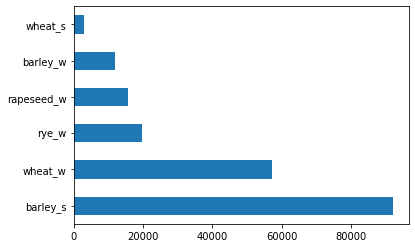

In [11]:
# category 3 Oct-Dec
classes_for_cat_3 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22],
    'barley_s': [1],
    'wheat_s' :[2,6]	
    }
denmark_veg_cat_3 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_3,id_col = 'code',label_name='classes')
denmark_veg_cat_3['r_classes'].value_counts().plot(kind='barh')


In [12]:
denmark_veg_cat_3.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','Oct_Dec.shp'))

Summmer and Winter crop categorisation

| Season      | crop |
| ----------- | ----------- |
| Winter      | barley_w, wheat_w, rapeseed_w, rye_w       |
| Summer   | barley_s,wheat_s,oats_s        |

| Season      | crop |
| ----------- | ----------- |
| Winter      | 706,220,10,11,13,707,221,709,710,222,14,15,22      |
| Summer/Spring   | 01,701,210,211,702,02,06,03,703,212        |




<AxesSubplot:>

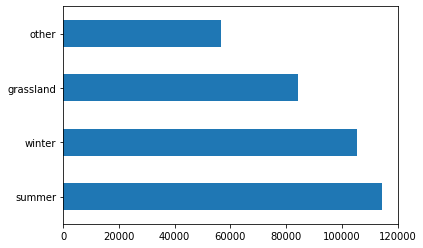

In [11]:
# category 3 Winter - Summer
classes_for_cat_4 = classes.whole_year
denmark_veg_cat_4 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_4,id_col = 'code',label_name='classes')
denmark_veg_cat_4['r_classes'].value_counts().plot(kind='barh')


In [19]:
np.unique(denmark_veg_cat_4.geometry.type)

array(['Polygon'], dtype=object)

In [12]:
print(denmark_veg_cat_4)
denmark_veg_cat_4.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','whole_summer_winter_2020.shp'))


         code                                           geometry  r_classes  \
14      264.0  POLYGON ((494053.127 6246316.224, 494043.286 6...  grassland   
21      263.0  POLYGON ((449836.761 6244522.326, 449847.961 6...  grassland   
29      263.0  POLYGON ((488867.569 6218451.897, 488915.463 6...  grassland   
30      263.0  POLYGON ((489314.407 6217987.254, 489314.464 6...  grassland   
31      263.0  POLYGON ((489298.445 6218157.059, 489315.584 6...  grassland   
...       ...                                                ...        ...   
583646   11.0  POLYGON ((476154.511 6292280.784, 476152.443 6...     winter   
583647    1.0  POLYGON ((476472.707 6291933.559, 476610.051 6...     summer   
583648   10.0  POLYGON ((482149.487 6290435.470, 482137.496 6...     winter   
583649   10.0  POLYGON ((482232.214 6290475.882, 482234.754 6...     winter   
583650   11.0  POLYGON ((476741.079 6291510.861, 476735.513 6...     winter   

        r_code  
14           4  
21           4  


NameError: name 'json' is not defined

In [ ]:
with open(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','whole_year_summer_winter_2020.json'), 'w') as fp:
    json.dump(classes_for_cat_4, fp)

<AxesSubplot:>

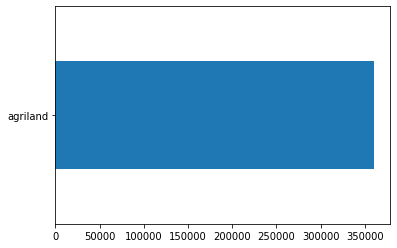

In [6]:
# category 6 agriculture land or not
classes_for_cat_6 = classes.agriculture_land
denmark_veg_cat_6 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_6,id_col = 'code',label_name='classes')
denmark_veg_cat_6['r_classes'].value_counts().plot(kind='barh')

In [ ]:
denmark_veg_cat_6.to_file(os.path.join(st.data_directory,'3','Reformatted','Denmark_shape_2020','whole_summer_winter_2020.shp'))
with open(os.path.join(st.data_directory,'3','Reformatted','Denmark_shape_2020','whole_year_summer_winter_2020.json'), 'w') as fp:
    json.dump(classes_for_cat_6, fp)

## Satellite Imagery Download

In [1]:
import geemap
import ee
import IPython

In [2]:

ee.Initialize()
Map = geemap.Map(center=[56.2639,9.5018], zoom=7)
Map

Map(center=[56.2639, 9.5018], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

In [3]:
denmark_geometry =ee.Geometry.Polygon(
        [[[8.06, 57.74],
          [10.62,57.74],
          [11.21, 57.31],
          [11.67, 56.74],
          [12.62,56.03],
          [12.64,55.81],
          [12.78,55.67],
          [12.79,55.64],
          [12.85,55.56],
          [12.57,54.94],
          [11.96, 54.55],
          [11.46, 54.60],
          [10.67,54.70],
          [9.937345,54.848469],
          [9.692023,54.828515],
          [9.636622,54.860250],
          [9.608859,54.890788],
          [9.485931,54.839107],
          [9.422113,54.830018],
          [9.343855,54.800103],
          [9.330371,54.804208],
          [9.329360,54.805617],
          [9.293550,54.808889],
          [9.292091,54.806168],
          [9.295584,54.803154],
          [9.250266,54.809606],
          [9.031632,54.876914],
          [8.778732,54.891528],
          [8.60156,54.910120],
          [8.50,55.05],
          [8.45,55.09],
          [8.06, 55.55]]], None, False);

In [20]:
# cloud precentage 2 for jan-sep and cloud percentage 10 for oct-dec
# Scale should be 10 as 10 m resolution for RGB in sentinel-2

# 5 images download.... 1. 2020, 2. Jan-Mar2020, 3. Apr-Jun2020 , 4. Jul-Sep2020, 5. Oct-Dec2020
# 4 images download.... 1. 2019, 2. Jan-Mar2019, 3. Apr-Jun2019 , 4. Jul-Sep2019, 

dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(denmark_geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',4)) \
    .filterDate('2019-07-01', '2019-09-30') \
    .select(['B2', 'B3', 'B4']);
mosaic = dataset.mosaic().clip(denmark_geometry);

sentinel_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min':0, 
    'max':3000
    
}




In [21]:

Map.addLayer(mosaic, sentinel_vis , 'mosaic');
Map.centerObject(denmark_geometry);
image,request = mosaic._apply_visualization(sentinel_vis)


In [22]:
task = ee.batch.Export.image.toDrive(image=image,  # an ee.Image object.
                                     region=denmark_geometry,  # an ee.Geometry object.
                                     description='denmark_export',
                                     folder='Fieldsegmentation_2019',
                                     fileNamePrefix='denmark',
                                     scale=10,
                                     crs='EPSG:4326',
                                     maxPixels = 1e12)
task.start()

In [23]:
task.status()

{'state': 'READY',
 'description': 'denmark_export',
 'creation_timestamp_ms': 1622044028368,
 'update_timestamp_ms': 1622044028368,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'KGPNFOFDKKCGF5AKXWOG5ZJI',
 'name': 'projects/earthengine-legacy/operations/KGPNFOFDKKCGF5AKXWOG5ZJI'}

In [2]:
shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(st.data_directory,cfg._preprocessed_denamark_shape_files_,'Denmark_shape_2020/Apr_Jun.shp'))
denmark_veg = shape_ex.import_shape()

In [3]:
denmark_veg.columns

Index(['code', 'r_classes', 'r_code', 'fid', 'geometry'], dtype='object')

In [7]:
np.unique(denmark_veg.r_classes)

array(['barley_s', 'barley_w', 'oats_s', 'rapeseed_w', 'rye_w', 'wheat_s',
       'wheat_w'], dtype=object)

# Generate data

Use generate_data.py script for generating data or you can use following cells for generating data in steps

## Preprocess each shape files

As mentioned above we have 5 scenario in order to address the problem of generalised region-independent segmentation model and the impact of crop cycle on model learning. Vegetation crops data divided on the basis of stages of crop cycle { planting, mid and harves}. One more dataset for classification of summer and winter crops.

In [3]:
denmark_shape_directory = 'Denmark_shape_2019'
reformatted_file_path = os.path.join(st.raw_shape_directory,'Reformatted',denmark_shape_directory)
_preprocessed_denamark_shape_files_ = 'Preprocessed_denamark_shape_files'
processed_file_path = os.path.join(st.data_directory,_preprocessed_denamark_shape_files_,denmark_shape_directory)

## Preprocess includes, 
# converting multipolygon to polygon
# Adding zero to corners where exploding is not perfect

for file in tqdm(os.listdir(reformatted_file_path)):
    file_type,filename = file.split('.')[1],file.split('.')[0]
    if file_type == 'shp':
        shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(reformatted_file_path,file))
        denmark_veg = shape_ex.import_shape()
        denmark_veg = shape_ex.explode(df = denmark_veg)
        denmark_veg = shape_ex.buffer_zero(denmark_veg)
        denmark_veg = denmark_veg.reset_index(drop=True)
        denmark_veg = denmark_veg.assign(fid=lambda _df: range(0, len(_df.index)))
        denmark_veg.to_file(os.path.join(processed_file_path,file))

  0%|          | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]
 25%|██▌       | 5/20 [01:26<04:20, 17.35s/it]
0it [00:00, ?it/s]
 40%|████      | 8/20 [02:18<03:27, 17.30s/it]
0it [00:00, ?it/s]
 60%|██████    | 12/20 [03:49<02:38, 19.80s/it]
0it [00:00, ?it/s]
100%|██████████| 20/20 [05:16<00:00, 15.84s/it]


# Clip shape files for each tif(image files)

So we have 5 images for whole 2020 : 

* Whole Year 2020
* Jan - March
* Apr - Jun
* Jul - Sep
* Oct - Dec

For each images, bound and clip the respective shape files to raster image and save into drive


In [ ]:
year = '2019'
denmark_shape_directory = 'Denmark_shape_2019'
_preprocessed_denamark_shape_files_ = 'Preprocessed_denamark_shape_files'

# create directory for saving processed files for year

year_processed = year+'_processed'
path = os.path.join(st.data_directory,year_processed)
try:
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Creation of the directory %s Success" % path)

denmark_tif = os.path.join(st.data_directory,'Denmark_tif',year)
processed_file_path = os.path.join(st.data_directory,_preprocessed_denamark_shape_files_,denmark_shape_directory)

image_size = cfg.data_generation_image_size

for directory in tqdm(os.listdir(denmark_tif)):
    shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(processed_file_path,str(directory)+'.shp'))
    denmark_veg = shape_ex.import_shape()
    denmark_veg = denmark_veg.to_crs("EPSG:4326")
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):

        with rasterio.open(os.path.join(denmark_tif,directory,file)) as src:
            raster_meta = src.meta
            raster_bounds = src.bounds
        


        filename = file.split('.')[0]

        df = shape_ex.clip(df = denmark_veg,clip_poly = shapely.geometry.box(*raster_bounds),keep_biggest_poly_ = True)
        print(np.unique(df.geometry.type))
        

        df = df.assign(area_sqm = df.geometry.area)

        path = os.path.join(st.data_directory,year_processed,'v_'+directory,cfg._version_processed_shape_files)
        try:
            os.makedirs(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Creation of the directory %s Success" % path)
        df.to_file(os.path.join(path,str(filename)+'.shp'))

## Crop vector files into chips

Crop vector(shape) into chips of defined image sizes for training purposes and later on crop raster tif into jpg according to cropped vectors. Cropped vectors saved into drives

In [ ]:
year = '2019'
denmark_shape_directory = 'Denmark_shape_2019'

# create directory for saving processed files for year
year_processed = year+'_processed'

image_size = cfg.data_generation_image_size
_preprocessed_denamark_shape_files_ = 'Preprocessed_denamark_shape_files'

denmark_tif = os.path.join(st.data_directory,'Denmark_tif','2019')
processed_file_path = os.path.join(st.data_directory,_preprocessed_denamark_shape_files_,denmark_shape_directory)



for directory in tqdm(os.listdir(denmark_tif)):
    count = 0
    file_name_image_id_count_dictionary = {}
    final_chip_dfs = {}
    version_path = os.path.join(st.data_directory,year_processed,'v_'+directory)
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):
        with rasterio.open(os.path.join(denmark_tif,directory,file)) as src:
            raster_meta = src.meta
            raster_bounds = src.bounds
        filename = file.split('.')[0]
        
        shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(version_path,cfg._version_processed_shape_files,str(filename)+'.shp'))
        denmark_veg = shape_ex.import_shape()
        prev = count
        chip_dfs,count = so.crop_vector_in_chips(df = denmark_veg,
                                             raster_width = raster_meta['width'],
                                             raster_height = raster_meta['height'],
                                             raster_transform = raster_meta['transform'],
                                             chip_width = image_size,
                                             chip_height=image_size,
                                             count = count,
                                             filename = filename,
                                             skip_partial_chips = True)
        
        path = os.path.join(version_path,str(image_size),'crop_chip_info')
        try:
            os.makedirs(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Creation of the directory %s Success" % path)
        
        chip_path = os.path.join(path,str(filename)+'.pickle')
        final_chip_dfs.update(chip_dfs)
        file_name_image_id_count_dictionary[filename] = list(range(prev, count))

        dictionary_utils.new_pickle(chip_path,chip_dfs)
        
    path = os.path.join(version_path,str(image_size),'final_crop_chip_info')
    try:
        os.makedirs(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Creation of the directory %s Success" % path)
        
    dictionary_utils.new_pickle(os.path.join(path,'chip_dfs.pickle'),final_chip_dfs)
    dictionary_utils.new_pickle(os.path.join(path,'file_name_image_id_count_dictionary.pickle'),file_name_image_id_count_dictionary)

## Crop Raster Images into chips as did for Vector

In [ ]:
year = '2019'
denmark_shape_directory = 'Denmark_shape_2019'

# create directory for saving processed files for year
year_processed = year+'_processed'

denmark_tif = os.path.join(st.data_directory,'Denmark_tif','2019')

image_size = cfg.train_image_size

for directory in tqdm(os.listdir(denmark_tif)):
    version_path = os.path.join(st.data_directory,year_processed,'v_'+directory)
    pickle_path = path = os.path.join(version_path,str(image_size),'final_crop_chip_info','file_name_image_id_count_dictionary.pickle')
    file_name_image_id_count_dictionary = dictionary_utils.load_pickle(pickle_path)
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):
        filename = file.split('.')[0]
        chip_dfsss = file_name_image_id_count_dictionary[filename]
        chip_windows={}
        raster_image_max = 2200 ## Value used while extracting the sentinel-2 image
        path = os.path.join(version_path,str(image_size),cfg._version_crop_images_)
        try:
            os.makedirs(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Creation of the directory %s Success" % path)
        for chip_no in chip_dfsss:
            chip_name = f'COCO_train2021_000000{100000 + chip_no}'
            chip_windows.update({chip_name:final_chip_dfs[chip_name]['chip_window']})
            
        stats = rf.cut_chip_images(inpath_raster = os.path.join(denmark_tif,directory,file),
                      outpath_chipfolder = path,
                      chip_names = chip_windows.keys(),
                      chip_windows = chip_windows.values(),
                      raster_image_range = raster_image_max)

## Save vectors in COCO annotations

In [2]:
image_size = cfg.train_image_size

denmark_tif = os.path.join(st.data_directory,'Denmark_tif','2020')
processed_file_path = os.path.join(st.data_directory,'Preprocessed_denamark_shape_files','Denmark_shape_2020')

for directory in tqdm(os.listdir(denmark_tif)):
    version_path = os.path.join(st.data_directory,'v_'+str(directory))
    pickle_path = path = os.path.join(version_path,str(image_size),'final_crop_chip_info','chip_dfs.pickle')
    
    
    file = directory + '.shp'
    shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(processed_file_path,file))
    denmark_veg = shape_ex.import_shape()
    
    final_chip_dfs = dictionary_utils.load_pickle(pickle_path)
    train_chip_dfs, val_chip_dfs = coco_utils.train_test_split(final_chip_dfs, test_size=0, seed=1)
    
    coco_train = coco_utils.format_coco(train_chip_dfs, image_size, image_size,denmark_veg)
    coco_val = coco_utils.format_coco(val_chip_dfs, image_size, image_size,denmark_veg)
    
    
        
    path_train = os.path.join(version_path,str(image_size),cfg._version_train_)
    path_val = os.path.join(version_path,str(image_size),cfg._version_validation_)
    
    try:
        os.makedirs(os.path.join(path_train,'images'))
        os.makedirs(os.path.join(path_train,'annotation'))
        os.makedirs(os.path.join(path_val,'images'))
        os.makedirs(os.path.join(path_val,'annotation'))
        
    except OSError:
        print ("Creation of the directory {0} and {1}  failed".format(path_train,path_val))
    else:
        print("Creation of the directory {0} and {1} Success".format(path_train,path_val))
    
    dictionary_utils.new_json(outpath = os.path.join(path_train,'annotation/train2020.json'),data=coco_train)
    dictionary_utils.new_json(outpath = os.path.join(path_val,'annotation/val2020.json'),data=coco_val)
    
    ## Split the images in train and validation
    #Split the cropped images into train and validation with the help of train_chip_dfs and val_chip_dfs 
    
    train_images, validation_images = list(train_chip_dfs.keys()) , list(val_chip_dfs.keys())
    
    cropped_path  = os.path.join(version_path,str(image_size),cfg._version_crop_images_)
    for image in validation_images:
        img = image.replace('val','train')
        copyfile(os.path.join(cropped_path,str(img)+'.jpg'), os.path.join(path_val,'images/'+str(image)+'.jpg'))
    
    for image in train_images:
        copyfile(os.path.join(cropped_path,str(image)+'.jpg'), os.path.join(path_train,'images/'+str(image)+'.jpg'))

  0%|          | 0/5 [00:00<?, ?it/s]

Loading from existing pickle file... /home/sami02/projects/thesis/Data/v_Apr_Jun/400/final_crop_chip_info/chip_dfs.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Apr_Jun/400/train_100 and /home/sami02/projects/thesis/Data/v_Apr_Jun/400/validation_0 Success
Writing new json file... /home/sami02/projects/thesis/Data/v_Apr_Jun/400/train_100/annotation/train2020.json
Writing new json file... /home/sami02/projects/thesis/Data/v_Apr_Jun/400/validation_0/annotation/val2020.json


 20%|██        | 1/5 [03:29<13:58, 209.73s/it]

Loading from existing pickle file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/400/final_crop_chip_info/chip_dfs.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/400/train_100 and /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/400/validation_0 Success
Writing new json file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/400/train_100/annotation/train2020.json
Writing new json file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/400/validation_0/annotation/val2020.json


 40%|████      | 2/5 [07:19<11:04, 221.48s/it]

Loading from existing pickle file... /home/sami02/projects/thesis/Data/v_Jan_Mar/400/final_crop_chip_info/chip_dfs.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Jan_Mar/400/train_100 and /home/sami02/projects/thesis/Data/v_Jan_Mar/400/validation_0 Success
Writing new json file... /home/sami02/projects/thesis/Data/v_Jan_Mar/400/train_100/annotation/train2020.json
Writing new json file... /home/sami02/projects/thesis/Data/v_Jan_Mar/400/validation_0/annotation/val2020.json


 60%|██████    | 3/5 [09:22<05:53, 176.56s/it]

Loading from existing pickle file... /home/sami02/projects/thesis/Data/v_Jul_Sep/400/final_crop_chip_info/chip_dfs.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Jul_Sep/400/train_100 and /home/sami02/projects/thesis/Data/v_Jul_Sep/400/validation_0 Success
Writing new json file... /home/sami02/projects/thesis/Data/v_Jul_Sep/400/train_100/annotation/train2020.json
Writing new json file... /home/sami02/projects/thesis/Data/v_Jul_Sep/400/validation_0/annotation/val2020.json


 80%|████████  | 4/5 [13:00<03:12, 192.94s/it]

Loading from existing pickle file... /home/sami02/projects/thesis/Data/v_Oct_Dec/400/final_crop_chip_info/chip_dfs.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Oct_Dec/400/train_100 and /home/sami02/projects/thesis/Data/v_Oct_Dec/400/validation_0 Success
Writing new json file... /home/sami02/projects/thesis/Data/v_Oct_Dec/400/train_100/annotation/train2020.json
Writing new json file... /home/sami02/projects/thesis/Data/v_Oct_Dec/400/validation_0/annotation/val2020.json


100%|██████████| 5/5 [16:27<00:00, 197.45s/it]



## Visualise the annotation and Images


In [3]:
# For Jan-March
image_size = cfg.train_image_size
v_Jan_Mar = os.path.join(st.data_directory,'v_Jan_Mar')
annotation_path = os.path.join(v_Jan_Mar,str(image_size),'train','annotation/train2020.json')
image_dir = os.path.join(v_Jan_Mar,str(image_size),'train','images')
coco_dataset = coco_utils.CocoDataset(annotation_path,image_dir)
coco_dataset.display_categories()

Categories:
  super_category: Agriculture
    id 1: barley_w
    id 2: wheat_w
    id 3: rye_w
    id 4: rapeseed_w



In [8]:
import IPython
html = coco_dataset.display_image(100061, show_polys=True, show_bbox=False, show_labels=True, show_crowds=False,
                      use_url=False)
IPython.display.HTML(html)

Image:
  file_name: COCO_train2021_000000100061.jpg
  id: 100061
  height: 800
  width: 800
  segmentations (144):


In [9]:

html = coco_dataset.display_image(100236, show_polys=True, show_bbox=False, show_labels=True, show_crowds=False,
                      use_url=False)
IPython.display.HTML(html)

Image:
  file_name: COCO_train2021_000000100236.jpg
  id: 100236
  height: 800
  width: 800
  segmentations (73):


In [10]:
# For Apr-Jun
v_Apr_Jun = os.path.join(st.data_directory,'v_Apr_Jun')
annotation_path = os.path.join(v_Apr_Jun,'train','annotation/train2020.json')
image_dir = os.path.join(v_Jan_Mar,'train','images')
coco_dataset = coco_utils.CocoDataset(annotation_path,image_dir)
coco_dataset.display_categories()

Categories:
  super_category: Agriculture
    id 1: barley_w
    id 2: wheat_w
    id 3: rye_w
    id 4: rapeseed_w
    id 5: barley_s
    id 6: wheat_s
    id 7: oats_s



In [11]:

html = coco_dataset.display_image(100587, show_polys=True, show_bbox=False, show_labels=True, show_crowds=False,
                      use_url=False)
IPython.display.HTML(html)

Image:
  file_name: COCO_train2021_000000100587.jpg
  id: 100587
  height: 800
  width: 800
  segmentations (231):


In [12]:
# For whole 2020
v_whole_summer_winter_2020 = os.path.join(st.data_directory,'v_whole_summer_winter_2020')
annotation_path = os.path.join(v_whole_summer_winter_2020,'train','annotation/train2020.json')
image_dir = os.path.join(v_Jan_Mar,'train','images')
coco_dataset = coco_utils.CocoDataset(annotation_path,image_dir)
coco_dataset.display_categories()

Categories:
  super_category: Agriculture
    id 1: winter
    id 2: summer



In [13]:

html = coco_dataset.display_image(100409, show_polys=True, show_bbox=False, show_labels=True, show_crowds=False,
                      use_url=False)
IPython.display.HTML(html)

Image:
  file_name: COCO_train2021_000000100409.jpg
  id: 100409
  height: 800
  width: 800
  segmentations (381):
